In [2]:
import os
from glob import glob

# The MNIST dataset

The MNIST dataset contains hand-drawn images of digits from 0 - 9. The digits were digitally drawn on a black canvas with white paint.

## Dataset structure

The [MNIST](https://www.kaggle.com/datasets/scolianni/mnistasjpg) dataset contains a `trainingSet` with the images and the corresponding label for each image. The `testSet` contains unlabeled images that we could run inference on.

# The image classifier

## The image classifier input & output

The image classifier will take in as input an image of a hand drawn image. Then it will analyze and give us a prediction on what it thinks the digit is.

## The image classifier architecture

The image classifier we are going to build is a Neural Network. Now the neural network will contain `linear layers` that will analyze the image and a `softmax layer` that will give us the prediction.

## Training the image classifer

To train our image classifier, we will need to feed our network images of the digits. The network will then give us a digit that it thinks the image represents. It is very likely that the network will answer wrong, because it hasn't learnt anything yet. To make it learn, we will punish it each time it makes a mistake and reward it each time it gives a correct answer. This punish and reward system will happen via a `loss function`.

# 1. Explore the dataset

In [3]:
# python variables are named using snake_case where a space ' ' is represented by an underscore '_'

# declaring a python variable with the = operator
ds_root = "./dataset/trainingSet/trainingSet" # the path to the dataset. The '.' represents the current folder this file is in

# the join function combines all the folders to create a path leading to the file
image_path = os.path.join(ds_root, "0", "img_1.jpg") # this outputs: dataset/trainingSet/trainingSet/0/img_1.jpg

# the print function is used to display
print(image_path)

./dataset/trainingSet/trainingSet/0/img_1.jpg


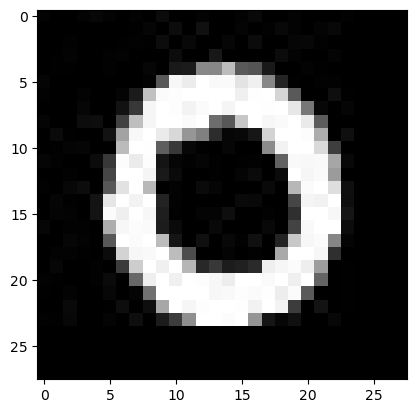

In [4]:
import matplotlib.pyplot as plt

# read the image using matplotlib
image =  plt.imread(image_path)

# show the image also using matplotlib
plt.imshow(image, cmap="gray")

Now looking at this image, most of us would know that this is a zero. This is because we've seen so many zeros in our life that the classification happens subconciously and we don't even have to actively think about it. 

After training, the Neural Network will also have the ability to recognize that this is a 0 *(hopefully)*.

In [5]:
# next, we'll quantitize our dataset to see how much training data we have

image_path_wild = os.path.join(ds_root, "**", "*.jpg") # the star '*' acts as a wildcard character. Meaning, any file that ends in .jpg will be selected

all_images = sorted(glob(image_path_wild)) # get all image paths and sort them

# show 10 first image path
print('first 10 images ---')
print(all_images[:10]) 

print('total image count')
print(len(all_images)) # the len returns the length of a list

first 10 images ---
['./dataset/trainingSet/trainingSet/0/img_1.jpg', './dataset/trainingSet/trainingSet/0/img_10007.jpg', './dataset/trainingSet/trainingSet/0/img_10010.jpg', './dataset/trainingSet/trainingSet/0/img_10017.jpg', './dataset/trainingSet/trainingSet/0/img_10032.jpg', './dataset/trainingSet/trainingSet/0/img_10039.jpg', './dataset/trainingSet/trainingSet/0/img_10043.jpg', './dataset/trainingSet/trainingSet/0/img_10059.jpg', './dataset/trainingSet/trainingSet/0/img_10074.jpg', './dataset/trainingSet/trainingSet/0/img_10082.jpg']
total image count
42000


In [6]:
# let's then see how many images each types of digits has

# in python, to use a loop, we use the `for` keyword
# the os.listdir function will list out all the top level files and folders in that directory
for folder in sorted(os.listdir(ds_root)): 
    image_in_folder_path_list = os.path.join(ds_root, folder, "*.jpg") # wildcard to select all .jpg files like before
    image_in_folder_list = glob(image_in_folder_path_list)

    print(f"The number of image for digit: {folder} is : {len(image_in_folder_list)}") # f"" is a formatted string where you can insert variables in

The number of image for digit: 0 is : 4132
The number of image for digit: 1 is : 4684
The number of image for digit: 2 is : 4177
The number of image for digit: 3 is : 4351
The number of image for digit: 4 is : 4072
The number of image for digit: 5 is : 3795
The number of image for digit: 6 is : 4137
The number of image for digit: 7 is : 4401
The number of image for digit: 8 is : 4063
The number of image for digit: 9 is : 4188


# 2. Splitting the dataset

After exploring the dataset, we now need to determine how much of it we are going to use to train the model, and how much of it we are going to use to test the model out on how its learning process is going.

The usual ratio for splitting the dataset is 80% training data and 20% testing data. To achieve this, we use the `train_test_split` function imported from `sklearn.model_selection`. The output of this function is an array of 2 items: `[train_data, test_data]`, and we will receive this into 2 varialbes using the form `x, y = [a, b]` where `x = a` and `y = b`.

In [7]:
from sklearn.model_selection import train_test_split

# to split the images, we will gather all the image path
all_images = sorted(glob(os.path.join(ds_root, "**", "*.jpg")))

train_split, test_split = train_test_split(all_images, test_size=0.2) # this will split the dataset into 80% training data and 20% testing data

print("number of images for training:")
print(len(train_split))

print("number of images for testing:")
print(len(test_split))

number of images for training:
33600
number of images for testing:
8400


# 3. Creating data loaders

We have successfully splitted the dataset into training data and testing data. Next, we need a way to get these images randomly at any arbitrary amount at a time so that we can feed them to the image classifier.

To do that, we will explore the `DataLoader` and `Dataset` classes from `PyTorch` and how we can define functions and classes in Python.
 
## Dataset

The purpoes of the Dataset is to return an image and its label based on any index we give it. For example if i give it index = 1, it will return the image at position 1 and its corresponding label. 

More specifically, the image has to be an array of values so that the neural network can understand and compute and these values have to be in floating point numbers. Ideally, the image values are also normalized in the range of $[0, 1]$ so that the model can better understand the values and not have sudden spike or drop in its performance.

## DataLoader

The purpose of the DataLoader is to batch and shuffle the dataset. Meaning, it will shuffle the dataset in random order and give out a batch of images and labels corresponding to the batch size we specify each time we tell it to. The DataLoader is also iterable, which allows us to loop through its elements (the image label pair).

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

# using the class keyword is how we define a class in Python
# when defining a class, anything in parenthesis means we are inheriting from that class too for our class definition
class MnistDataset(Dataset):
    """
    inherting from the torch.utils.data.Dataset class to make our dataset compatible with the PyTorch API
    """
    def __init__(self, image_path): 
        """
        the init method is called when you first instantiate an instance of this class
        arguments:
        image_path: all the image path available in the dataset
        """
        self.image_path = image_path

    def __len__(self):
        """
        this function returns the length of the dataset when the len() function is invoked
        """
        return len(self.image_path)

    def __getitem__(self, index):
        """
        this function will return the image and its label according to the index argument
        argument:
        index: the order of the iamge label pair of the dataset
        """
        image_path = self.image_path[index] # the image path will have the form "./dataset/trainingSet/trainingSet/0/img_1.jpg"

        # converts this into a numpy array and normalize its values in the range [0, 1] because the max value inside any image is 255
        image_array = np.array(plt.imread(image_path))  / 255 
        image_tensor = torch.from_numpy(image_array).float()

        label = int(image_path.split("/")[-2]) # get the folder of the path

        return [image_tensor, label]

In [9]:
# this is how we initialize a class instance, by calling the class name
train_dataset = MnistDataset(image_path=train_split) # all the variables in the initialization will be received by the __init__ method
test_dataset = MnistDataset(image_path=test_split)

print("train dataset length:", len(train_dataset))

image, label = train_dataset[0] # the index will be received by the __getitem__ method

print("image array shape: ", image.shape)
print("image label: ", label)

train dataset length: 33600
image array shape:  torch.Size([28, 28])
image label:  2


In [10]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

images, labels = next(iter(train_loader))

print("number of images in each step out of loader: ", len(images))
print("number of labels in each step out of loader: ", len(labels))

number of images in each step out of loader:  8
number of labels in each step out of loader:  8


# 4. Model

The model architecture includes a `Flatten` layer and 5 `Linear` layers, of which 4 are normal layers and the final one is the output layer.

1. The `Flatten` layer is to flatten our image with *width* and *height* of `28px x 28px` to a flat array with size of $28 * 28 = 784$ numbers. 
2. The `Linear` layer is a matrix multiplication of the input and the output. The main idea of the linear is to transform the output into some matrix of different dimensions that the model can understand better. Many linear layers also exposes many different features of the image.
3. The output `Linear` layer has the output of shape: $10$ which is the number of digits avaiable. This layer transform the model's understanding of the image into its choices. The $10$ numbers in the model output is how confidence the model is on which digit the image is supposed to be. For example, the output of the model is: `[1, 4, 2, 8, 7, 4, 1, 1, 2, 6]`, the model is most confident that the image is the number $3$ since the score at number $3$ is $8$.

The `forward` method is used to process the input with each of the model layers. It takes an argumnt `x` as the input, which is the normalized image array. It then calls the `flatten` layer to flatten the image into a $1D$ array. Then it calls the linear layers consecutively to extract important features from the image. Finally, it calls the `output` layer to transform the array into an array of its choices.

In [11]:
import torch.nn as nn

class ImageClassifer(nn.Module):
    def __init__(self, image_width=28, image_height=28, num_classes=10):
        super().__init__()

        flatten_dim = image_width * image_height

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.linear_1 = nn.Linear(in_features=flatten_dim, out_features=flatten_dim)
        self.linear_2 = nn.Linear(in_features=flatten_dim, out_features=flatten_dim)
        self.linear_3 = nn.Linear(in_features=flatten_dim, out_features=flatten_dim)
        self.linear_4 = nn.Linear(in_features=flatten_dim, out_features=flatten_dim)

        self.out = nn.Linear(in_features=flatten_dim, out_features=num_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.linear_2(x)
        x = self.linear_3(x)
        x = self.linear_4(x)
        x = self.out(x)

        return x

In [12]:
images, labels = next(iter(train_loader))
model = ImageClassifer()

In [13]:
out = model(images)
print("output shape: ", out.shape)

output shape:  torch.Size([8, 10])


# 5. Train the model

This is the training loop to train the model. It involves punishing the model through the `loss_fn` variable, which is the loss function. The model is then optimized based on the loss function with the `optimizer`.

In [ ]:
from tqdm import tqdm

def train_one_epoch(model : ImageClassifer, loader : DataLoader, optimizer, loss_fn, device=torch.device("cuda")):
    model.train(True)

    # training loop
    running_loss = 0
    pbar = tqdm(enumerate(loader), total=len(loader), desc="Step: 0 | Train loss: 0")

    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(images)

        loss = loss_fn(output, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    pbar.set_description_str(f"Step: {len(loader) - 1} | Train loss: {running_loss / len(loader)}")

    return running_loss / len(loader)

def test_one_epoch(model : ImageClassifer, loader : DataLoader, loss_fn, device=torch.device("cuda")):
    model.eval()

    # training loop
    running_loss = 0
    pbar = tqdm(enumerate(loader), total=len(loader), desc="Step: 0 | Test loss: 0")

    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)

        loss = loss_fn(output, labels)

        running_loss += loss.item()

    pbar.set_description_str(f"Step: {len(loader) - 1} | Test loss: {running_loss / len(loader)}")
    return running_loss / len(loader)

In [15]:
# define train variables
epochs = 10

device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = ImageClassifer(image_width=28, image_height=28, num_classes=10).to(device=device)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

best_loss = 10000000

print("START TRAINING")
print("---------")

for epoch in tqdm(range(epochs)):
    train_epoch_loss = train_one_epoch(model=model, loader=train_loader, optimizer=optimizer, loss_fn=loss_fn, device=device)
    test_epoch_loss = test_one_epoch(model=model, loader=test_loader, loss_fn=loss_fn, device=device)

    if test_epoch_loss < best_loss:
        print(f"Model improved on epoch: {epoch} | Train loss: {train_epoch_loss} | Test loss: {test_epoch_loss}")
        best_loss = test_epoch_loss
    else:
        print(f"Model did not improve on epoch: {epoch} | Train loss: {train_epoch_loss} | Test loss: {test_epoch_loss}")

START TRAINING
---------


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:18<00:00, 228.88it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:02<00:00, 376.05it/s]
 10%|█         | 1/10 [00:21<03:10, 21.15s/it]

Model improved on epoch: 0 | Train loss: 0.4911493768742574 | Test loss: 0.30721497509229395


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:13<00:00, 304.70it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 740.87it/s]
 20%|██        | 2/10 [00:36<02:21, 17.65s/it]

Model improved on epoch: 1 | Train loss: 0.3057368470230583 | Test loss: 0.28482894851426993


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:14<00:00, 299.79it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 707.24it/s]
 30%|███       | 3/10 [00:51<01:56, 16.67s/it]

Model improved on epoch: 2 | Train loss: 0.28421957896589967 | Test loss: 0.27135212562534783


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:13<00:00, 310.94it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 775.66it/s]
 40%|████      | 4/10 [01:06<01:35, 15.96s/it]

Model did not improve on epoch: 3 | Train loss: 0.2714838197438179 | Test loss: 0.27924839487809333


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:12<00:00, 323.34it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 763.49it/s]
 50%|█████     | 5/10 [01:21<01:16, 15.38s/it]

Model did not improve on epoch: 4 | Train loss: 0.26369083186722403 | Test loss: 0.27697781750865813


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:13<00:00, 305.15it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 710.98it/s]
 60%|██████    | 6/10 [01:36<01:01, 15.34s/it]

Model did not improve on epoch: 5 | Train loss: 0.2560197709147663 | Test loss: 0.28830520308709573


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:13<00:00, 306.62it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 722.05it/s]
 70%|███████   | 7/10 [01:51<00:45, 15.28s/it]

Model did not improve on epoch: 6 | Train loss: 0.2515537507950683 | Test loss: 0.2749253794839162


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:14<00:00, 299.28it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 707.92it/s]
 80%|████████  | 8/10 [02:07<00:30, 15.35s/it]

Model did not improve on epoch: 7 | Train loss: 0.24707590051078504 | Test loss: 0.2788832645807859


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:13<00:00, 303.78it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 711.48it/s]
 90%|█████████ | 9/10 [02:22<00:15, 15.34s/it]

Model did not improve on epoch: 8 | Train loss: 0.24263886714293179 | Test loss: 0.2791783282426851


Step: 0 | Train loss: 0: 100%|██████████| 4200/4200 [00:13<00:00, 307.56it/s]
Step: 0 | Test loss: 0: 100%|██████████| 1050/1050 [00:01<00:00, 752.77it/s]
100%|██████████| 10/10 [02:37<00:00, 15.74s/it]

Model did not improve on epoch: 9 | Train loss: 0.23945006547185282 | Test loss: 0.2835142897242414


In [ ]:
model_iteration = 0
torch.save(model.state_dict(), f"./model/model_{str(model_iteration).zfill(5)}.pt") # saving the trained model

# 6. Running inference with our model

After our model has been trained, we can now use it to predict what is written on the images. To do this, we first put the model in inference mode. Then, we pass it the image array and finally, we convert its input into a final choice using $argmax$ since the output of the model is an array of chioces where the largest element is what the model thinks the image is.

In [22]:
import math

In [24]:
# the def keyword is how we define a function in Python. Inside the parenthesis are arguments that is pass to the functions. Default arguments can be initialized using the = operator

def inference(model : ImageClassifer, image, device = torch.device("cuda")):
    model.eval()

    image = image.to(device)

    # this output is an array of 10 numbers, each numbers represent how confidence the model is that the image represents the digit of that index
    output = model(image)
    
    # this is to get the index of the largest number, which is also the choice that the model is most confident in
    output_argmax = torch.argmax(output, dim=-1)

    return output_argmax

In [20]:
test_images, test_labels = next(iter(test_loader))

print("test image shape: ", test_images.shape)
print("test label shape: ", test_labels.shape)

test image shape:  torch.Size([8, 28, 28])
test label shape:  torch.Size([8])


In [ ]:
output = inference(model, test_images)
print("model output: ", output) # each number in this array is the model's prediction for what the image at that index is representing. For example, at image position 0, the model thinks it is the number 9

model output:  tensor([9, 8, 5, 1, 6, 1, 4, 7], device='cuda:0')


In [51]:
def plot(images, choices):
    assert images.shape[0] == choices.shape[0], print("Error, the number of images and the number of predictions is not matching")

    max_col = 4
    array_length = choices.shape[0] 
    nrows = math.floor(array_length / 4) if array_length % 4 == 0 else math.floor(array_length / 4) + 1

    fig, axes = plt.subplots(nrows=nrows, ncols=max_col, figsize=(15, 5 * nrows))

    for row in range(nrows):
        for col in range(4):
            index = 4 * row + col

            if index < array_length:
                axes[row][col].imshow(images[index], cmap="gray")
                axes[row, col].set_title(f"Model predicts: {choices[index]}")
                axes[row][col].axis('off')  # Hide axes for better visualization
            else:
                axes[row][col].axis('off')

    plt.show()

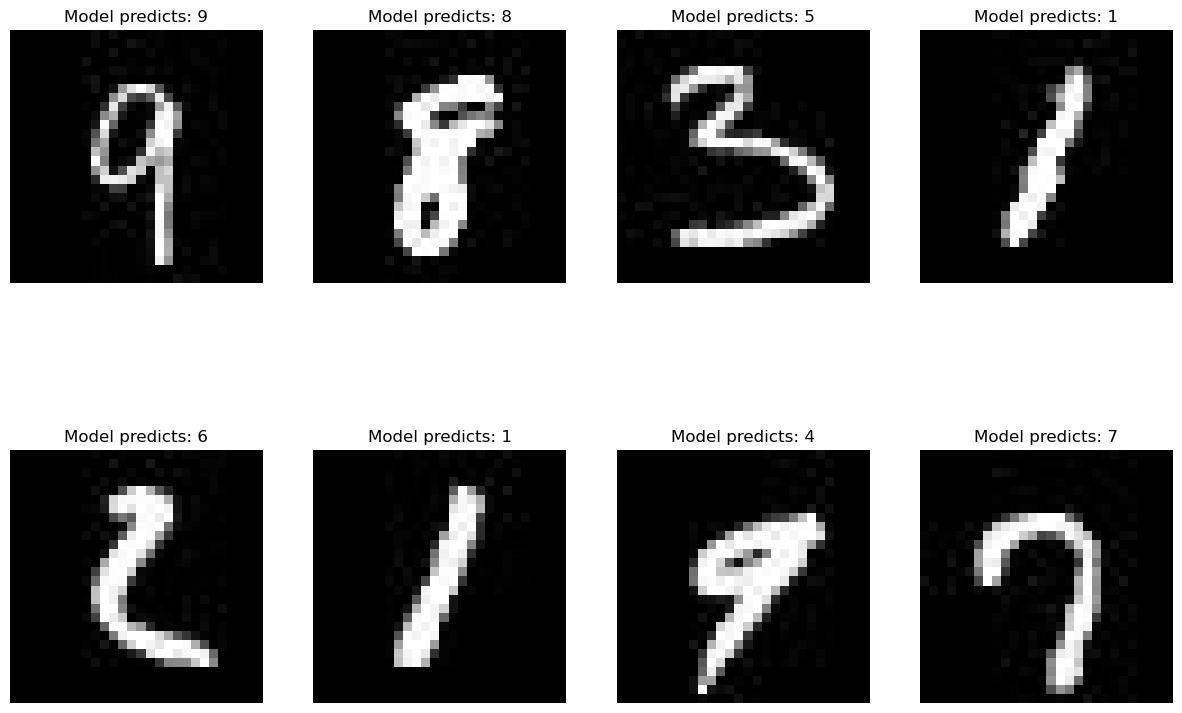

In [52]:
plot(images=test_images, choices=output)

With just a bit of training, the model's prediction is relatively correct, though we can see it gets confused when the digits are too similar to each other. In real applications, we improve the model's accuracy by doing much more data preprocessing and using a bigger, better model. This ensures the accuracy of the model is high enough to solve the task at hand.